**Oбучение с подкреплением**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np

In [2]:
# !pip3 install gym
# !pip3 install gym[atari]
# !pip3 install gym[accept-rom-license]
# !pip3 install pygame

# https://pypi.org/project/gym-notebook-wrapper/

# !pacman -S xorg-server-xvfb
# !pip3 install pyvirtualdisplay
# !pip3 install xvfbwrapper


# !pip3 install box2d

# !pip3 install mujoco_py  # env_name = 'Ant-v3'
# !pip3 install ale-py     # !ale-import-roms roms/


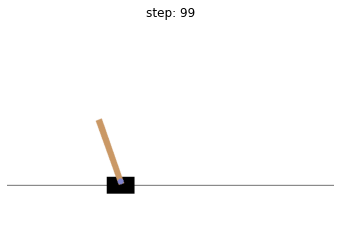

In [3]:
# блокируем всплывающее окно gym env
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800,600))
display.start()

import matplotlib.pyplot as plt
from IPython import display
import gym 

env_name = 'CartPole-v1'
# env_name = 'Pendulum-v1' 

env = gym.make(env_name)
obs = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
plt.grid(False)
plt.axis(False)

for i in range(100):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    plt.title(f'step: {i}')
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # if done: break
        
env.close()

In [4]:
# obs, reward, done

---

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from keras.layers import Dropout
# from keras.optimizers import SGD

def create_model(env):
    md = Sequential()
    md.add(Dense(32, activation='relu',input_shape=env.observation_space.shape))
    md.add(Dense(32, activation='relu'))
    md.add(Dense(env.action_space.n))
    md.compile(loss='mean_squared_error', optimizer='SGD')
    #md.add(Dense(env.action_space.n, activation='softmax'))
    #md.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4))
    return md

In [6]:
import copy

model = create_model(env)
# model_target = create_model(env)
model_target = copy.deepcopy(model)

2022-05-29 19:56:01.079903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 19:56:01.105263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 19:56:01.105556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 19:56:01.106561: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

INFO:tensorflow:Assets written to: ram://c50345fe-68f3-4667-a3e2-b0a4a8046a9f/assets


In [7]:
HISTORY_DEEP = 2000 # глубина истории переходов
BATCH_SIZE = 32 # размер батча для обучения модели

GAMMA = 0.85 # коэффициент для расчёта оценки reward
TAU = 0.125 # определяет различие весов основной и таргет моделей

# вероятность использования случайного действия при обучении
EPSILON_MAX = 1.0 # в начальном состоянии используем случайный выбор действия
EPSILON_MIN = 0.05 # когда модель начала обучаться позволяем ей оценивать действия
EPSILON_DECAY = 0.995 # шаг изменения вероятности

MAX_EPOCH = 100 # максимальное количество эпох обучения
MAX_STEP = 200 # максимальное количество шагов в эпохе (длительность одной игры)

MIN_STEP = 120

MIN_STEP = MIN_STEP if (MIN_STEP<MAX_STEP) else MAX_STEP-1

In [8]:
def reshape_state(s): return s[np.newaxis,:]

In [9]:
# выбор действия
def get_action(model,state,eps=EPSILON_MAX): # с вероятностью eps выбираем случайное действие
    if np.random.rand()<eps: return env.action_space.sample(), 1
    return np.argmax( model.predict( state )[0] ), 0

In [10]:
def replay(model, model_target, history, batch_size=BATCH_SIZE,gamma=GAMMA):

    if len(history) < batch_size: return
    
    samples = [ history[i] for i in np.random.permutation(len(history))[:batch_size] ] 

    for s in samples:
        target = model_target.predict( s['state0'] )
        
        target[0][ s['act'] ] = s['reward'] 
        
        if s['isdone']:
            target[0][ s['act'] ] = s['reward']
        else:
            target[0][ s['act'] ] = s['reward'] + gamma*max(model_target.predict(s['state1'])[0])
            
        # model.fit( s['state0'], target, epochs=1, verbose=0)
        model.train_on_batch(s['state0'], target)

In [11]:
def target_train(model, model_target,tau=TAU):
    weights = model.get_weights()
    target_weights = model_target.get_weights()
    for i in range(len(target_weights)):
        target_weights[i] = weights[i] * tau + target_weights[i] * (1. - tau)
    model_target.set_weights(target_weights)

In [12]:
%%time

history = []

epsilon = EPSILON_MAX # вероятность использования случайного действия при обучении

for e in range(MAX_EPOCH):
    # инициализируем среду
    state0 = env.reset() 
    state0 = reshape_state(state0)
    for st in range(MAX_STEP):
        
        # выбираем действие
        act, is_act_rand = get_action(model,state0,epsilon)
        # применяем действие
        state1, reward, done, _ = env.step(act)
        state1 = reshape_state(state1)
    
        # сохраняем историю
        history.append({'state0':state0,'state1':state1,'act':act,'reward':reward,'isdone':done})
        history = history[-HISTORY_DEEP:] # ограничиваем историю

        # коррекция основной модели
        replay(model, model_target, history)
        
        # коррекция таргет модели
        target_train(model, model_target)
                
        if done: break
        state0 = state1
        epsilon = max(EPSILON_MIN, epsilon*EPSILON_DECAY)
                
    print('%d/%d : %d steps'%(e+1,MAX_EPOCH,st+1))  
    
    if st>MIN_STEP: 
        print('STEP BOUND!')
        break

1/100 : 14 steps
2/100 : 21 steps
3/100 : 15 steps
4/100 : 50 steps
5/100 : 31 steps
6/100 : 53 steps
7/100 : 30 steps
8/100 : 60 steps
9/100 : 61 steps
10/100 : 25 steps
11/100 : 200 steps
STEP BOUND!
CPU times: user 18min 46s, sys: 32.1 s, total: 19min 18s
Wall time: 17min 59s


In [13]:
model_name = f'CartPole-{st}.model'
model.save(model_name)

INFO:tensorflow:Assets written to: CartPole-199.model/assets


---

In [14]:
# model_name = 'CartPole-170.model'

In [15]:
from keras.models import load_model
model_ = load_model(model_name)

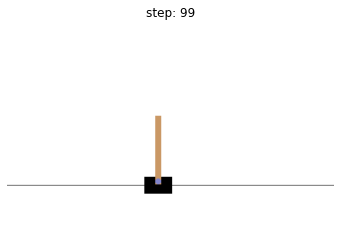

In [19]:
# блокируем всплывающее окно gym env
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800,600))
display.start()

import matplotlib.pyplot as plt
from IPython import display
import gym 

# env_name = 'CartPole-v1'
# env_name = 'Pendulum-v1' 

env = gym.make(env_name)
obs = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
plt.grid(False)
plt.axis(False)

for i in range(100):
    # action = env.action_space.sample()
    action = np.argmax( model_.predict(obs[np.newaxis,:])[0] )   
    obs, reward, done, info = env.step(action)

    plt.title(f'step: {i}')
    img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    if done: break
        
env.close()

---

In [17]:
# # блокируем всплывающее окно gym env
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(800,600))
# display.start()

# import matplotlib.pyplot as plt
# from IPython import display
# import gym 

# # env_name = 'Pendulum-v1' 
# # env_name = 'BreakoutNoFrameskip-v4'
# env_name = 'SpaceInvaders-v0'

# env = gym.make(env_name)
# obs = env.reset()

# img = plt.imshow(env.render(mode='rgb_array'))
# plt.grid(False)
# plt.axis(False)

# for i in range(100):
#     action = env.action_space.sample()
#     obs, reward, done, info = env.step(action)

#     plt.title(f'step: {i}')
#     img.set_data(env.render(mode='rgb_array')) 
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    
#     if done: break
        
# env.close()

---

In [18]:
# !pip3 install watermark
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.8.9
IPython version      : 8.0.1

tensorflow: 2.8.0
numpy     : 1.22.2
gym       : 0.23.1
IPython   : 8.0.1
matplotlib: 3.5.1

